In [1]:
!pip install obonet --quiet

In [3]:
import pandas as pd
import obonet
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

Bắt đầu lan truyền dữ liệu
1. Đang đọc file annotations...
   - Số dòng raw: 537,027

2. Đang load GO Graph ...

3. Đang tính toán tổ tiên ...


100%|██████████| 40122/40122 [00:01<00:00, 23918.49it/s]


   - Bỏ qua 0 term lỗi thời.

4. Lan truyền nhãn cho từng Protein...


82404it [00:03, 21653.89it/s]



>>> Đang lưu file: train_terms_propagated.tsv
Saved!

>>> PHẦN B: THỐNG KÊ DỮ LIỆU SAU KHI LAN TRUYỀN
Tổng số annotations (Propagated): 3,949,607
Số protein unique: 82,404
Số GO terms unique: 29,616

--- 1. TOP/BOTTOM LABELS ---
5 nhãn phổ biến nhất:
term
GO:0005575    60292
GO:0008150    59958
GO:0110165    59516
GO:0003674    58001
GO:0009987    52146
Name: count, dtype: int64

5 nhãn hiếm nhất:
term
GO:0035665    1
GO:0035664    1
GO:1902203    1
GO:2001113    1
GO:0102628    1
Name: count, dtype: int64

--- 2. LABELS PER PROTEIN ---
Trung bình: 47.93
Median: 33.0
Max: 892

--- 3. PROTEINS PER LABEL ---
Trung bình: 133.36
Median: 8.0
Max: 60292

--- 4. VISUALIZATION (PLOTS) ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


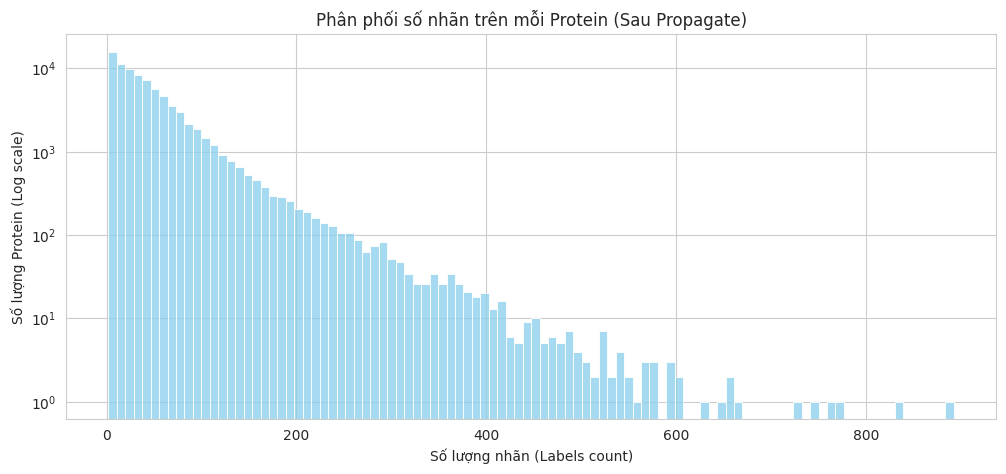

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


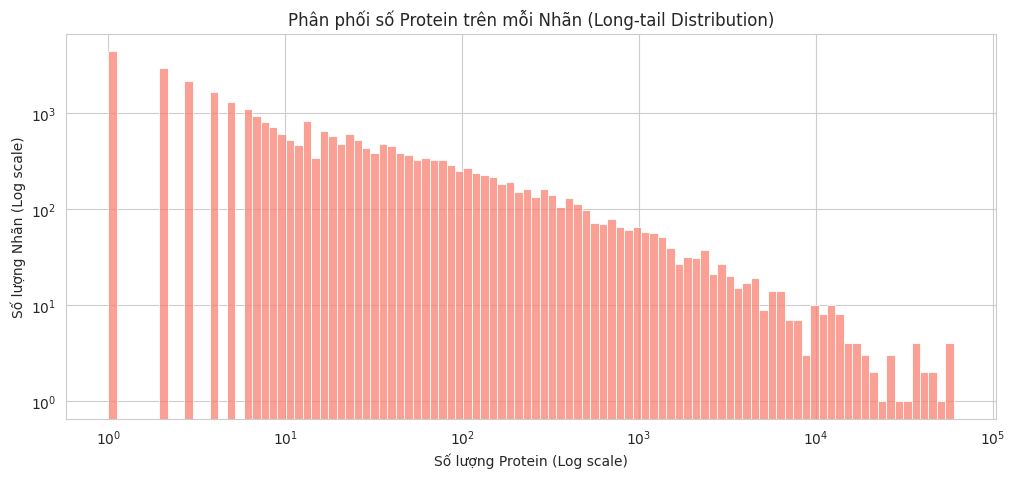


--- 5. RARE LABELS ANALYSIS ---
Tổng số nhãn: 29,616
Nhãn xuất hiện đúng 1 lần: 4,438 (14.99%)
Nhãn xuất hiện <= 5 lần : 12,515 (42.26%)
Nhãn xuất hiện <= 10 lần: 16,709 (56.42%)
Nhãn xuất hiện <= 50 lần: 24,102 (81.38%)

--- 6. CUMULATIVE COVERAGE ---
Tổng số annotations dùng để tính toán: 3,949,607
Số nhãn cần để cover 50% annotation: 174 labels
Số nhãn cần để cover 70% annotation: 654 labels
Số nhãn cần để cover 90% annotation: 3,378 labels
Số nhãn cần để cover 95% annotation: 6,416 labels
Số nhãn cần để cover 99% annotation: 15,585 labels

✅ HOÀN TẤT TOÀN BỘ QUÁ TRÌNH!


In [4]:


# ======================================================
# CONFIG
# ======================================================
TRAIN_TERMS_PATH = "/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv"
OBO_FILE_PATH = "/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo"
OUTPUT_FILE = "train_terms_propagated.tsv"

# ======================================================
# XỬ LÝ DỮ LIỆU (PROPAGATION)
# ======================================================
print("Bắt đầu lan truyền dữ liệu")

# 1. LOAD DỮ LIỆU RAW
print("1. Đang đọc file annotations...")
df_raw = pd.read_csv(TRAIN_TERMS_PATH, sep="\t")

if "EntryID" in df_raw.columns:
    df_raw = df_raw.rename(columns={"EntryID": "protein", "aspect": "raw_aspect"})
elif "protein" not in df_raw.columns:
    df_raw.columns = ["protein", "term", "raw_aspect"]

print(f"   - Số dòng raw: {len(df_raw):,}")

# 2. LOAD GO GRAPH
print("\n2. Đang load GO Graph ...")
go_graph = obonet.read_obo(OBO_FILE_PATH)

NAMESPACE_MAP = {'biological_process': 'BPO', 'molecular_function': 'MFO', 'cellular_component': 'CCO'}

# 3. PRE-COMPUTE ANCESTORS
print("\n3. Đang tính toán tổ tiên ...")
term_metadata = {}
obsolete_count = 0

for node in tqdm(go_graph.nodes()):
    node_data = go_graph.nodes[node]
    if node_data.get('is_obsolete') == 'true':
        obsolete_count += 1
        continue

    ancestors = nx.descendants(go_graph, node)
    ancestors.add(node) 
    
    ns = node_data.get('namespace', 'unk')
    aspect_code = NAMESPACE_MAP.get(ns, ns)
    
    term_metadata[node] = {'ancestors': ancestors, 'aspect': aspect_code}

print(f"   - Bỏ qua {obsolete_count} term lỗi thời.")

# 4. PROPAGATION
print("\n4. Lan truyền nhãn cho từng Protein...")
grouped = df_raw.groupby("protein")["term"].apply(list)
prop_data = []

for protein, terms in tqdm(grouped.items()):
    final_terms_set = set()
    for term in terms:
        if term in term_metadata:
            final_terms_set.update(term_metadata[term]['ancestors'])
        else:
            final_terms_set.add(term)
            
    for t in final_terms_set:
        aspect = term_metadata[t]['aspect'] if t in term_metadata else 'Unk'
        prop_data.append((protein, t, aspect))

df_propagated = pd.DataFrame(prop_data, columns=["protein", "term", "aspect"])

print(f"\n>>> Đang lưu file: {OUTPUT_FILE}")
df_propagated.to_csv(OUTPUT_FILE, sep="\t", index=False, header=False)
print("Saved!")

# ======================================================
# THỐNG KÊ CHI TIẾT 
# ======================================================
print("\n" + "="*60)
print(">>> PHẦN B: THỐNG KÊ DỮ LIỆU SAU KHI LAN TRUYỀN")
print("="*60)

train_terms = df_propagated 

print(f"Tổng số annotations (Propagated): {len(train_terms):,}")
print(f"Số protein unique: {train_terms['protein'].nunique():,}")
print(f"Số GO terms unique: {train_terms['term'].nunique():,}")

# ------------------------------
# 1) Tần suất xuất hiện của từng GO term
# ------------------------------
term_counts = train_terms["term"].value_counts()

print("\n--- 1. TOP/BOTTOM LABELS ---")
print("5 nhãn phổ biến nhất:")
print(term_counts.head())

print("\n5 nhãn hiếm nhất:")
print(term_counts.tail())

# ------------------------------
# 2) Phân phối số nhãn / protein
# ------------------------------
labels_per_protein = train_terms.groupby("protein")["term"].nunique()

print("\n--- 2. LABELS PER PROTEIN ---")
print(f"Trung bình: {labels_per_protein.mean():.2f}")
print(f"Median: {labels_per_protein.median()}")
print(f"Max: {labels_per_protein.max()}")

# ------------------------------
# 3) Phân phối số protein / nhãn
# ------------------------------
proteins_per_label = term_counts

print("\n--- 3. PROTEINS PER LABEL ---")
print(f"Trung bình: {proteins_per_label.mean():.2f}")
print(f"Median: {proteins_per_label.median()}")
print(f"Max: {proteins_per_label.max()}")

# ------------------------------
# 4) Plot phân phối (Visualisation)
# ------------------------------
print("\n--- 4. VISUALIZATION (PLOTS) ---")
sns.set_style("whitegrid")

# Biểu đồ 1: Số nhãn trên mỗi protein
plt.figure(figsize=(12, 5))
sns.histplot(labels_per_protein, bins=100, log_scale=(False, True), color='skyblue')
plt.title("Phân phối số nhãn trên mỗi Protein (Sau Propagate)")
plt.xlabel("Số lượng nhãn (Labels count)")
plt.ylabel("Số lượng Protein (Log scale)")
plt.show()

# Biểu đồ 2: Số protein trên mỗi nhãn (Long-tail check)
plt.figure(figsize=(12, 5))
# Dùng log-log scale để nhìn rõ đuôi dài
sns.histplot(proteins_per_label, bins=100, log_scale=(True, True), color='salmon')
plt.title("Phân phối số Protein trên mỗi Nhãn (Long-tail Distribution)")
plt.xlabel("Số lượng Protein (Log scale)")
plt.ylabel("Số lượng Nhãn (Log scale)")
plt.show()

# ------------------------------
# 5) Đếm % nhãn hiếm
# ------------------------------
print("\n--- 5. RARE LABELS ANALYSIS ---")
total_labels = len(proteins_per_label)
rare_1 = (proteins_per_label == 1).sum()
rare_5 = (proteins_per_label <= 5).sum()
rare_10 = (proteins_per_label <= 10).sum()
rare_50 = (proteins_per_label <= 50).sum()

print(f"Tổng số nhãn: {total_labels:,}")
print(f"Nhãn xuất hiện đúng 1 lần: {rare_1:,} ({rare_1 / total_labels * 100:.2f}%)")
print(f"Nhãn xuất hiện <= 5 lần : {rare_5:,} ({rare_5 / total_labels * 100:.2f}%)")
print(f"Nhãn xuất hiện <= 10 lần: {rare_10:,} ({rare_10 / total_labels * 100:.2f}%)")
print(f"Nhãn xuất hiện <= 50 lần: {rare_50:,} ({rare_50 / total_labels * 100:.2f}%)")

# ------------------------------
# 6) Tính % nhãn chiếm X% annotation (Cumulative Coverage)
# ------------------------------
print("\n--- 6. CUMULATIVE COVERAGE ---")
total_annot = term_counts.sum()
sorted_counts = term_counts.sort_values(ascending=False)
cumulative = sorted_counts.cumsum() / total_annot

print(f"Tổng số annotations dùng để tính toán: {total_annot:,}")

for pct in [0.5, 0.7, 0.9, 0.95, 0.99]:
    needed = (cumulative <= pct).sum()
    print(f"Số nhãn cần để cover {pct*100:.0f}% annotation: {needed:,} labels")

print("\n HOÀN TẤT TOÀN BỘ QUÁ TRÌNH!")

In [ ]:
import pandas as pd
import os

# =========================================================
# CẤU HÌNH
# =========================================================
INPUT_FILE = "/kaggle/working/train_terms_propagated.tsv"
ROOT_TERMS = {"GO:0003674", "GO:0005575", "GO:0008150"}

# =========================================================
# 1. LOAD DỮ LIỆU
# =========================================================
print(f"Đang đọc file: {INPUT_FILE} ...")
df = pd.read_csv(INPUT_FILE, sep="\t", names=["protein", "term", "aspect"])

print(f"Tổng annotations: {len(df):,}")

# Tạo map term -> aspect để dùng cho file vocab
term_aspect_map = df[['term', 'aspect']].drop_duplicates().set_index('term')['aspect'].to_dict()

# Đếm tần suất trên toàn bộ dữ liệu (bao gồm cả Root)
term_counts = df["term"].value_counts()
total_annot = term_counts.sum()
sorted_counts = term_counts.sort_values(ascending=False)
cumulative = sorted_counts.cumsum() / total_annot

# =========================================================
# 2. HÀM XỬ LÝ & LƯU FILE
# =========================================================
def generate_datasets(coverage, label_name):
    print(f"\n" + "="*50)
    print(f">>> ĐANG XỬ LÝ BỘ {label_name} (COVERAGE {coverage*100}%)")
    print("="*50)
    
    # 1. Xác định số lượng nhãn cần thiết
    needed = (cumulative <= coverage).sum()
    top_terms = sorted_counts.head(needed).index.tolist()
    
    print(f"Tổng số nhãn đạt coverage {coverage*100}%: {len(top_terms)}")
    
    # 2. Tạo 2 danh sách nhãn: Keep Root và Remove Root
    terms_keep = top_terms
    terms_remove = [t for t in top_terms if t not in ROOT_TERMS]
    
    versions = {
        "keep": terms_keep,
        "remove": terms_remove
    }
    
    # 3. Vòng lặp tạo file cho từng phiên bản
    for v_type, v_terms in versions.items():
        suffix = f"{label_name}_{v_type}" # Ví dụ: C95_keep hoặc C95_remove
        
        print(f"\n   --- Phiên bản: {v_type.upper()} ROOT ---")
        print(f"   Số nhãn: {len(v_terms)}")
        
        # A. LƯU VOCAB (Kèm Aspect)
        vocab_data = [{'term': t, 'aspect': term_aspect_map.get(t, 'Unk')} for t in v_terms]
        vocab_df = pd.DataFrame(vocab_data)
        
        vocab_filename = f"vocab_{suffix}.csv"
        vocab_df.to_csv(vocab_filename, index=False)
        print(f"   [Vocab] Saved: {vocab_filename}")
        
        # B. LƯU TRAIN DATA (Lọc từ DataFrame gốc)
        # Chỉ giữ lại các dòng có term nằm trong danh sách v_terms
        v_terms_set = set(v_terms)
        filtered_df = df[df["term"].isin(v_terms_set)]
        
        train_filename = f"train_data_{suffix}.tsv"
        filtered_df.to_csv(train_filename, sep="\t", header=False, index=False)
        print(f"   [Train] Saved: {train_filename}")
        print(f"   -> Annotations: {len(filtered_df):,}")
        print(f"   -> Proteins: {filtered_df['protein'].nunique():,}")

# =========================================================
# 3. CHẠY TRÊN 3 MỨC ĐỘ
# =========================================================

# Chạy cho 90%
generate_datasets(0.90, "C90")

# Chạy cho 95%
generate_datasets(0.95, "C95")

# Chạy cho 99%
generate_datasets(0.99, "C99")

print("\n" + "="*50)
print("✅ HOÀN TẤT! ĐÃ TẠO ĐỦ 6 FILE TRAINING VÀ 6 FILE VOCAB.")

## 